In [38]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import normalize
from keras.optimizers import SGD
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier 
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

In [39]:
# Reading the dataset
df = pd.read_csv("../data/aggregated.csv")

df = df.sample(50000)

# Let's have a look
df.head(3)

,MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,Unnamed: 13
4921268,1.0,1.0,2017-01-02,B6,716.0,JAX,"Jacksonville, FL",DCA,"Washington, DC",1955.0,0.0,100.0,634.0,NaN
568006,11.0,4.0,2016-11-03,AA,1893.0,CLT,"Charlotte, NC",AUS,"Austin, TX",2205.0,0.0,172.0,1032.0,NaN
121859,2.0,6.0,2017-02-18,UA,878.0,IAD,"Washington, DC",HDN,"Hayden, CO",900.0,0.0,260.0,1582.0,NaN


In [40]:
# Let's convert this date string to a date object
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'],
                              format = '%Y-%m-%d',
                              errors = 'coerce')

# Let's extract the day and year, we already have the month
df['DAY_OF_MONTH'] = df['FL_DATE'].dt.day
df['YEAR'] = df['FL_DATE'].dt.year

### I will drop some of the columns:
- `FL_DATE`: Because I have the month, day of the week, day of the month, and year separately.
- `ORIGIN_CITY_NAME`: Because the airport code will be enough.
- `DEST_CITY_NAME`: Because the airport code will be enough.
- `Unnamed: 13`: Because it is null for every row.

In [41]:
# Getting rid of the necessary columns
df.drop(['FL_DATE',
        'ORIGIN_CITY_NAME',
        'DEST_CITY_NAME',
        'Unnamed: 13'], axis=1, inplace=True)

# We are left with this
df.head(3)

,MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,DAY_OF_MONTH,YEAR
4921268,1.0,1.0,B6,716.0,JAX,DCA,1955.0,0.0,100.0,634.0,2,2017
568006,11.0,4.0,AA,1893.0,CLT,AUS,2205.0,0.0,172.0,1032.0,3,2016
121859,2.0,6.0,UA,878.0,IAD,HDN,900.0,0.0,260.0,1582.0,18,2017


In [42]:
# Let's have a look at our null values
df.isna().sum()[df.isna().sum()!=0]

ARR_DEL15           652
CRS_ELAPSED_TIME      1
dtype: int64

### I will drop rows where `ARR_DEL15` is null since that is what we are predicting.
### I will drop rows where `CRS_ELAPSED_TIME` is null since there are only 10 such rows.

In [61]:
# Getting rid of thos null values
df.dropna(inplace=True)

# Our data still looks mostly the same, but it is cleaned up now
df.head(3)

,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,COS_MONTH,SIN_MONTH,COS_DAY_OF_WEEK,SIN_DAY_OF_WEEK
4921268,2,716.0,156,76,1955.0,0.0,100.0,634.0,-2.449294e-16,1.0,-2.449294e-16,1.0
568006,0,1893.0,63,20,2205.0,0.0,172.0,1032.0,-9.799650e-15,1.0,-9.797174e-16,1.0
121859,9,878.0,141,128,900.0,0.0,260.0,1582.0,-4.898587e-16,1.0,-1.469576e-15,1.0


### I will use `LabelEncoder` to turn `ORIGIN`,  `DEST`, and `UNIQUE_CARRIER` to numbers.

In [44]:
# Here's a LabelEncoder fit to ORIGIN
le = LabelEncoder().fit(df['ORIGIN'])
# Here I transform the column to those numbers
df['ORIGIN'] = le.transform(df['ORIGIN'])

# Here's a LabelEncoder fit to DEST
le = LabelEncoder().fit(df['DEST'])
# Here I transform the column to those numbers
df['DEST'] = le.transform(df['DEST'])

# Here's a LabelEncoder fit to UNIQUE_CARRIER
le = LabelEncoder().fit(df['UNIQUE_CARRIER'])
# Here I transform the column to those numbers
df['UNIQUE_CARRIER'] = le.transform(df['UNIQUE_CARRIER'])

# # Here's a LabelEncoder fit to UNIQUE_CARRIER
# le = LabelEncoder().fit(df['FL_DATE'])
# # Here I transform the column to those numbers
# df['FL_DATE'] = le.transform(df['FL_DATE'])

In [25]:
df['DAY_OF_WEEK'] = [np.cos(e) for e in df['DAY_OF_WEEK']]

df['MONTH'] = [np.cos(e) for e in df['MONTH']]

df['DAY_OF_MONTH'] = [np.cos(e) for e in df['DAY_OF_MONTH']]


In [47]:
# Here is the data
df.head(3)

,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15,CRS_ELAPSED_TIME,DISTANCE,COS_MONTH,SIN_MONTH,COS_DAY_OF_WEEK,SIN_DAY_OF_WEEK,COS_DAY_OF_MONTH,SIN_DAY_OF_MONTH
4921268,2,716.0,156,76,1955.0,0.0,100.0,634.0,-2.449294e-16,1.0,-2.449294e-16,1.0,-4.898587e-16,1.0
568006,0,1893.0,63,20,2205.0,0.0,172.0,1032.0,-9.799650e-15,1.0,-9.797174e-16,1.0,-7.347881e-16,1.0
121859,9,878.0,141,128,900.0,0.0,260.0,1582.0,-4.898587e-16,1.0,-1.469576e-15,1.0,-4.408728e-15,1.0


In [55]:
df.drop(['COS_DAY_OF_MONTH', 'SIN_DAY_OF_MONTH'], inplace=True, axis=1)

In [11]:
df.drop(['DAY_OF_MONTH', 'YEAR'], axis=1, inplace=True)

In [56]:
# We are ready to do a train and test data split
# Let's first separate our input and output variables

# Input variables
X = df.drop(['ARR_DEL15'], axis=1)

# Output variables
y = df['ARR_DEL15']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [57]:
rf = RandomForestClassifier(random_state=42)

In [58]:
%%time

rf.fit(X_train, y_train)

CPU times: user 5.45 s, sys: 64.5 ms, total: 5.52 s
Wall time: 5.54 s


RandomForestClassifier(random_state=42)

In [59]:
%%time

predictions = rf.predict(X_test)

CPU times: user 216 ms, sys: 3.33 ms, total: 219 ms
Wall time: 218 ms


In [60]:
precision_score(y_test, predictions)

0.25471698113207547

In [97]:
#converting to numpy arrays prior to fitting into the model
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)     
y_test = np.asarray(y_test)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [98]:
%%time

rf.fit(X_train_res, y_train_res)

predictions = rf.predict(X_test)

precision_score(y_test, predictions)

CPU times: user 11.8 s, sys: 63.6 ms, total: 11.9 s
Wall time: 11.9 s


0.42391304347826086

In [117]:
df

df.drop(['UNIQUE_CARRIER', 'FL_NUM'], axis=1, inplace=True)

array([[<AxesSubplot:xlabel='MONTH', ylabel='MONTH'>,
        <AxesSubplot:xlabel='DAY_OF_WEEK', ylabel='MONTH'>,
        <AxesSubplot:xlabel='CRS_DEP_TIME', ylabel='MONTH'>,
        <AxesSubplot:xlabel='ARR_DEL15', ylabel='MONTH'>,
        <AxesSubplot:xlabel='CRS_ELAPSED_TIME', ylabel='MONTH'>,
        <AxesSubplot:xlabel='DISTANCE', ylabel='MONTH'>,
        <AxesSubplot:xlabel='DAY_OF_MONTH', ylabel='MONTH'>,
        <AxesSubplot:xlabel='YEAR', ylabel='MONTH'>],
       [<AxesSubplot:xlabel='MONTH', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='DAY_OF_WEEK', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='CRS_DEP_TIME', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='ARR_DEL15', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='CRS_ELAPSED_TIME', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='DISTANCE', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='DAY_OF_MONTH', ylabel='DAY_OF_WEEK'>,
        <AxesSubplot:xlabel='YEAR', ylabel='DAY_OF_WEEK'>],
       [<Axe

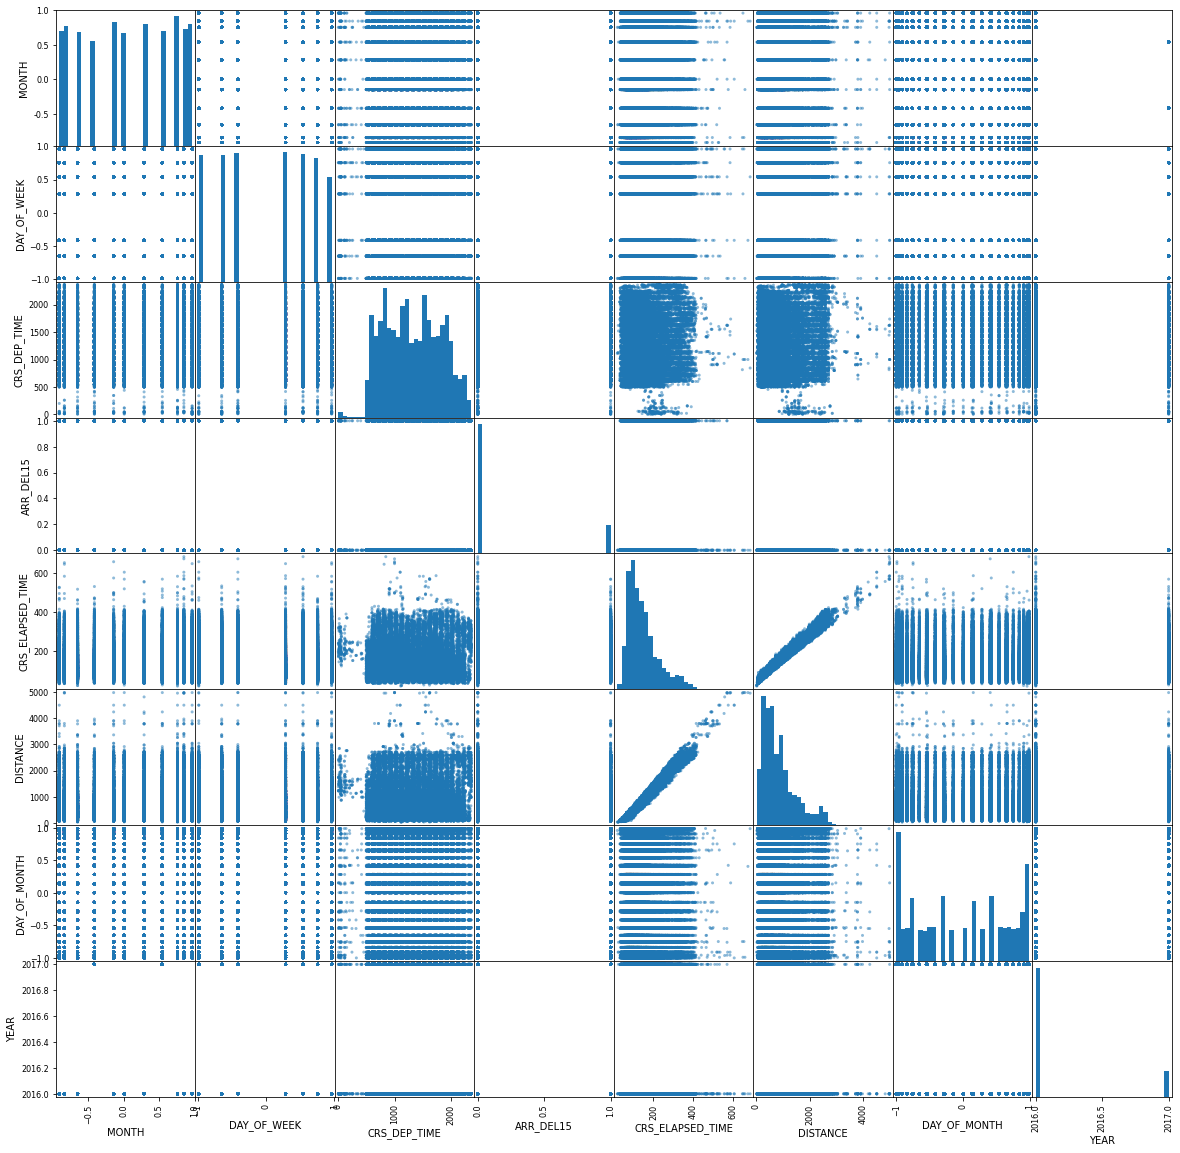

In [120]:
pd.plotting.scatter_matrix(df, figsize=(20,20), hist_kwds={'bins':30})